Cell 1: Initial Setup with SeisBench Download

In [ ]:
# -*- coding: utf-8 -*-
"""
Seismogram_Based_MO_INSTANCE_Preprocessing.ipynb

This notebook processes the INSTANCE dataset for seismogram-based splitting,
which treats each seismogram as an independent sample.
"""

# Install and import required packages
!pip install seisbench
!pip install torch torchvision torchaudio
!pip install h5py pandas tqdm matplotlib torchinfo seaborn

from google.colab import drive
import time
import os
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import torch
from collections import defaultdict
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal
import seisbench.data as sbd

# Start time
start_time = time.time()

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Mount Google Drive for output directory only
drive.mount('/content/drive')

# Set SeisBench to use local VM storage to avoid quota issues
os.environ['SEISBENCH_CACHE_ROOT'] = '/content/.seisbench'
print(f"SeisBench cache root: {os.environ['SEISBENCH_CACHE_ROOT']}")

# Download INSTANCE dataset using SeisBench
print("Downloading INSTANCE dataset using SeisBench...")
print("This will download to local VM storage, avoiding Google Drive quota issues...")
instance = sbd.InstanceCounts()

# Get paths to the downloaded files
instance_path = instance.path
metadata_path = os.path.join(instance_path, "metadata.csv")
hdf5_path = os.path.join(instance_path, "waveforms.hdf5")

# Output directory for seismogram-based results
output_dir = "/content/drive/My Drive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/INSTANCE_Seismogram_Based/Lower_Half_EpiDis"
os.makedirs(output_dir, exist_ok=True)

# Verify files exist
print(f"INSTANCE dataset path: {instance_path}")
print(f"Files in INSTANCE dataset folder:")
print(os.listdir(instance_path))

assert os.path.isfile(metadata_path), f"Metadata file not found at {metadata_path}"
assert os.path.isfile(hdf5_path), f"HDF5 file not found at {hdf5_path}"

print(f"✓ Using SeisBench INSTANCE files:")
print(f"  Metadata: {metadata_path}")
print(f"  HDF5: {hdf5_path}")
print(f"✓ Output directory: {output_dir}")

Using device: cpu
Mounted at /content/drive
SeisBench cache root: /content/.seisbench
This will download to local VM storage, avoiding Google Drive quota issues...


2025-08-26 16:14:31,217 | seisbench | WARNING | Dataset InstanceCounts not in cache.
2025-08-26 16:14:31,218 | seisbench | WARNING | Trying to download preprocessed version from SeisBench repository.
2025-08-26 18:00:51,086 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


INSTANCE dataset path: /root/.seisbench/datasets/instancecounts
Files in INSTANCE dataset folder:
['waveforms.hdf5', 'metadata.csv']
✓ Using SeisBench INSTANCE files:
  Metadata: /root/.seisbench/datasets/instancecounts/metadata.csv
  HDF5: /root/.seisbench/datasets/instancecounts/waveforms.hdf5
✓ Output directory: /content/drive/My Drive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/INSTANCE_Seismogram_Based/Lower_Half_EpiDis


Cell 2: Data Loading and Initial Filtering

Initial number of metadata entries: 1159249


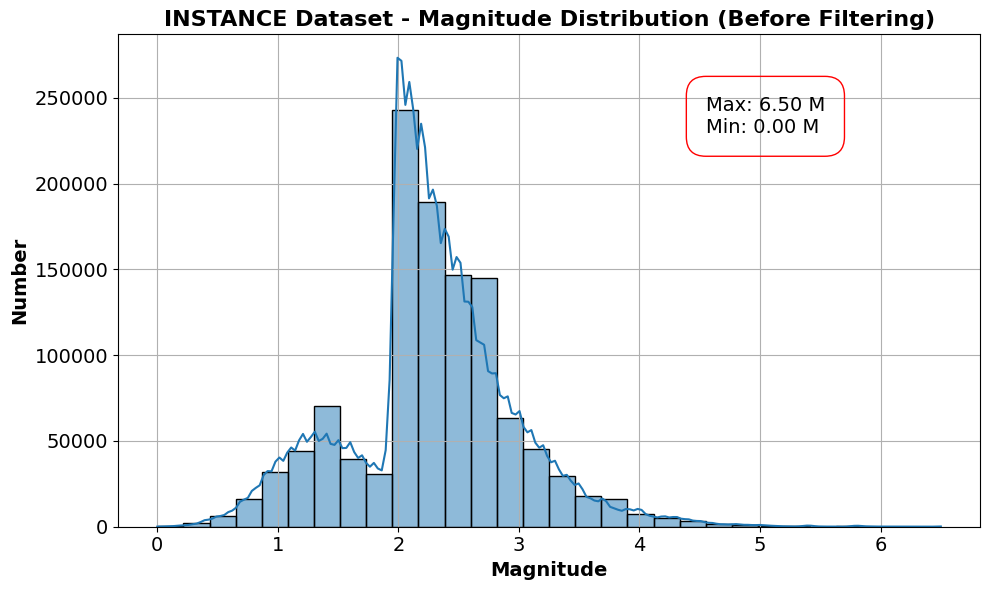

Number of metadata entries now: 1159249


In [ ]:
"""Cell 2: Data Loading and Initial Filtering"""

# Load and access the metadata from the CSV file
metadata = pd.read_csv(metadata_path, low_memory=False)
print(f"Initial number of metadata entries: {len(metadata)}")

# Ensure the 'source_origin_time' column is in datetime format
metadata['source_origin_time'] = pd.to_datetime(metadata['source_origin_time'])

# Sort by source_origin_time to ensure chronological order
metadata = metadata.sort_values(by='source_origin_time')

#================No need to filter by date from September 2018 onwards since we want all data================
# # Filter metadata for dates from September 2018 onwards
# from datetime import datetime, timezone
# start_date = datetime(2018, 9, 1, tzinfo=timezone.utc)
# metadata = metadata[metadata['source_origin_time'] >= start_date]
# print(f"Number of metadata entries from 1st September 2018 to 31st January 2020: {len(metadata)}")
#=============================================================================================================

# Plot the histogram of the earthquake magnitudes before filtering
plt.figure(figsize=(10, 6))
sns.histplot(metadata["source_magnitude"], bins=30, kde=True)
plt.xlabel('Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
max_magnitude = metadata["source_magnitude"].max()
min_magnitude = metadata["source_magnitude"].min()
plt.text(0.7*max_magnitude, plt.gca().get_ylim()[1]*0.8,
         f'Max: {max_magnitude:.2f} M\nMin: {min_magnitude:.2f} M',
         bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'), fontsize=14)
plt.title('INSTANCE Dataset - Magnitude Distribution (Before Filtering)', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

print(f"Number of metadata entries now: {len(metadata)}")

Cell 3: Apply Data Filtering Criteria

In [ ]:
"""Cell 3: Apply Data Filtering Criteria"""

import copy

# Create a deep copy of the metadata
filtered_metadata = copy.deepcopy(metadata)

# Set sampling rate
filtered_metadata['trace_sampling_rate_hz'] = 100

# Filtering for INSTANCE dataset within 30s window
filters = [
    ('path_ep_distance_km <= 110', filtered_metadata.path_ep_distance_km <= 110),
    ('source_magnitude_type == ML', filtered_metadata.source_magnitude_type == 'ML'),
    ('trace_P_arrival_sample.notnull()', filtered_metadata.trace_P_arrival_sample.notnull()),
    ('path_travel_time_P_s.notnull()', filtered_metadata.path_travel_time_P_s.notnull()),
    ('path_travel_time_P_s > 0', filtered_metadata.path_travel_time_P_s > 0),
    ('path_ep_distance_km.notnull()', filtered_metadata.path_ep_distance_km.notnull()),
    ('path_ep_distance_km > 0', filtered_metadata.path_ep_distance_km > 0),
    ('source_depth_km.notnull()', filtered_metadata.source_depth_km.notnull()),
    ('source_magnitude.notnull()', filtered_metadata.source_magnitude.notnull()),
    ('path_backazimuth_deg.notnull()', filtered_metadata.path_backazimuth_deg.notnull()),
    ('path_backazimuth_deg > 0', filtered_metadata.path_backazimuth_deg > 0),
]

# Apply filters one by one and keep track of the data
for desc, filt in filters:
    filtered_metadata = filtered_metadata[filt]
    print(f"After filter '{desc}': {len(filtered_metadata)} entries")

# Ensure at least 30 seconds of data after P-arrival
filtered_metadata = filtered_metadata[filtered_metadata.trace_P_arrival_sample + filtered_metadata.trace_sampling_rate_hz * 30 <= filtered_metadata.trace_npts]
print(f"After ensuring 30s after P arrival: {len(filtered_metadata)} entries")

# Calculate time window statistics
filtered_metadata['window_start'] = filtered_metadata.trace_P_arrival_sample - filtered_metadata.trace_sampling_rate_hz * 5  # 5 seconds before P arrival
filtered_metadata['window_end'] = filtered_metadata.trace_P_arrival_sample + filtered_metadata.trace_sampling_rate_hz * 25  # 25 seconds after P arrival (total 30s window)

# Ensure window start is not negative
filtered_metadata = filtered_metadata[filtered_metadata.window_start >= 0]
print(f"After ensuring non-negative window start: {len(filtered_metadata)} entries")

print(f"\nFinal number of filtered metadata entries: {len(filtered_metadata)}")

After filter 'path_ep_distance_km <= 110': 1010113 entries


/tmp/ipython-input-1401241529.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'source_magnitude_type == ML': 979936 entries


/tmp/ipython-input-1401241529.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'trace_P_arrival_sample.notnull()': 979936 entries


/tmp/ipython-input-1401241529.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_travel_time_P_s.notnull()': 979936 entries


/tmp/ipython-input-1401241529.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_travel_time_P_s > 0': 979936 entries


/tmp/ipython-input-1401241529.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_ep_distance_km.notnull()': 979936 entries


/tmp/ipython-input-1401241529.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_ep_distance_km > 0': 979936 entries


/tmp/ipython-input-1401241529.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'source_depth_km.notnull()': 979936 entries


/tmp/ipython-input-1401241529.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'source_magnitude.notnull()': 979936 entries


/tmp/ipython-input-1401241529.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_backazimuth_deg.notnull()': 979936 entries


/tmp/ipython-input-1401241529.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_backazimuth_deg > 0': 979761 entries
After ensuring 30s after P arrival: 979757 entries
After ensuring non-negative window start: 979755 entries

Final number of filtered metadata entries: 979755


Cell 4: Apply SNR Filter and Multi-Observations

Number of records after SNR filtering: 407164


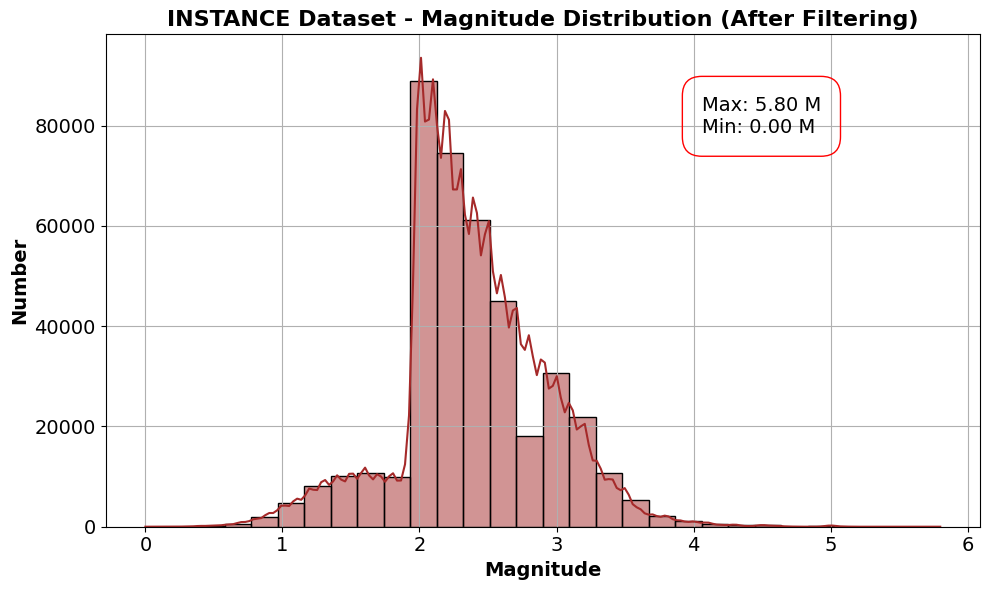

Filtering for multi-observations stations...
Counting observations per station...


  1%|          | 5/594 [00:00<00:29, 20.11it/s]

CING: 3055 observations
MURB: 4209 observations
BADI: 1280 observations
GRI: 675 observations


  1%|▏         | 8/594 [00:00<00:29, 20.19it/s]

RNI2: 834 observations
MIDA: 926 observations


  2%|▏         | 11/594 [00:00<00:28, 20.13it/s]

VAGA: 844 observations
INTR: 1812 observations
GUAR: 590 observations


  2%|▏         | 14/594 [00:00<00:28, 20.07it/s]

FAGN: 3955 observations
VVLD: 877 observations


  3%|▎         | 17/594 [00:00<00:28, 20.10it/s]

MRLC: 506 observations
FIAM: 4520 observations


  4%|▍         | 23/594 [00:01<00:28, 20.23it/s]

MNS: 618 observations
CERT: 1160 observations
SFI: 1159 observations
FNVD: 671 observations
TIP: 577 observations


  4%|▍         | 26/594 [00:01<00:27, 20.31it/s]

TERO: 11019 observations
AOI: 427 observations


  5%|▍         | 29/594 [00:01<00:28, 20.13it/s]

SACS: 571 observations
CAMP: 3871 observations
ERBM: 414 observations
MRB1: 400 observations


  7%|▋         | 41/594 [00:02<00:27, 20.13it/s]

SACR: 430 observations
BSSO: 568 observations
CRE: 464 observations
VLC: 1046 observations


  8%|▊         | 47/594 [00:02<00:26, 20.27it/s]

AQU: 5115 observations
CEL: 862 observations


  9%|▉         | 56/594 [00:02<00:26, 20.51it/s]

CUC: 1667 observations
GIB: 590 observations
MGR: 712 observations


 11%|█         | 65/594 [00:03<00:25, 20.35it/s]

BDI: 1723 observations
VULT: 400 observations


 12%|█▏        | 71/594 [00:03<00:25, 20.29it/s]

VCEL: 2776 observations
ARVD: 2166 observations
PLAC: 607 observations


 13%|█▎        | 77/594 [00:03<00:25, 20.21it/s]

CDRU: 480 observations
ORI: 401 observations
SERS: 634 observations


 14%|█▍        | 86/594 [00:04<00:25, 20.15it/s]

SCHR: 487 observations
MSAG: 1061 observations
SGRT: 705 observations


 15%|█▌        | 92/594 [00:04<00:24, 20.09it/s]

OFFI: 1646 observations
CERA: 863 observations
SIRI: 1483 observations
MTSN: 499 observations


 16%|█▋        | 98/594 [00:04<00:24, 20.09it/s]

JOPP: 1257 observations
MCEL: 799 observations
GALF: 893 observations


 18%|█▊        | 104/594 [00:05<00:24, 20.03it/s]

BULG: 488 observations
CRMI: 584 observations


 19%|█▉        | 113/594 [00:05<00:23, 20.16it/s]

POFI: 925 observations
SSY: 874 observations


 21%|██        | 122/594 [00:06<00:23, 20.09it/s]

MSRU: 844 observations
IVPL: 733 observations
ACER: 482 observations


 22%|██▏       | 128/594 [00:06<00:23, 20.07it/s]

ASQU: 625 observations
HAVL: 400 observations


 23%|██▎       | 134/594 [00:06<00:22, 20.10it/s]

PIEI: 2442 observations
CAFI: 1011 observations
CDCA: 576 observations
MILZ: 442 observations


 24%|██▍       | 143/594 [00:07<00:22, 20.09it/s]

FSSB: 1475 observations
FDMO: 6690 observations
CESI: 6033 observations
LNSS: 6209 observations
MGAB: 2859 observations
PARC: 871 observations


 25%|██▌       | 149/594 [00:07<00:22, 20.07it/s]

MTCE: 476 observations
LPEL: 1047 observations
MELA: 583 observations


 27%|██▋       | 161/594 [00:07<00:21, 20.01it/s]

CESX: 2443 observations
ASSB: 2222 observations
GUMA: 7527 observations


 29%|██▊       | 170/594 [00:08<00:21, 20.08it/s]

NRCA: 18010 observations
ROVR: 534 observations
MAIM: 408 observations
PZZ: 430 observations


 31%|███       | 182/594 [00:09<00:20, 20.10it/s]

T0104: 1986 observations


 32%|███▏      | 191/594 [00:09<00:20, 20.08it/s]

T0106: 439 observations
IACL: 492 observations


 33%|███▎      | 197/594 [00:09<00:19, 20.15it/s]

MMN: 965 observations
SMA1: 5503 observations
SALB: 1246 observations


 35%|███▌      | 209/594 [00:10<00:19, 20.20it/s]

SNTG: 5397 observations


 38%|███▊      | 224/594 [00:11<00:18, 20.10it/s]

ATVO: 1560 observations
ATPC: 932 observations
ATFO: 1692 observations
ATPI: 1312 observations


 39%|███▊      | 230/594 [00:11<00:18, 20.10it/s]

HLNI: 649 observations
CAR1: 750 observations
IFIL: 591 observations


 40%|████      | 239/594 [00:11<00:17, 20.08it/s]

NOV: 756 observations
RM33: 8680 observations


 42%|████▏     | 248/594 [00:12<00:17, 20.19it/s]

FRON: 1901 observations
MPNC: 798 observations
SSFR: 5856 observations
SLCN: 439 observations
ATTE: 823 observations


 43%|████▎     | 254/594 [00:12<00:16, 20.13it/s]

MCSR: 636 observations
PTQR: 400 observations
MUCR: 802 observations
CPGN: 593 observations


 44%|████▍     | 260/594 [00:12<00:16, 20.18it/s]

ATCC: 4133 observations
POPM: 537 observations


 46%|████▌     | 272/594 [00:13<00:16, 20.07it/s]

MPAG: 1213 observations
CET2: 667 observations


 47%|████▋     | 278/594 [00:13<00:15, 20.08it/s]

NARO: 760 observations
SSP9: 609 observations


 48%|████▊     | 284/594 [00:14<00:15, 20.09it/s]

ATMI: 998 observations
MDAR: 913 observations
ARRO: 2425 observations
SEF1: 1236 observations


 49%|████▉     | 290/594 [00:14<00:15, 20.06it/s]

FEMA: 4320 observations


 52%|█████▏    | 311/594 [00:15<00:13, 20.36it/s]

COR1: 563 observations


 54%|█████▍    | 323/594 [00:16<00:13, 20.26it/s]

FIU1: 504 observations
MOMA: 2665 observations


 55%|█████▌    | 329/594 [00:16<00:13, 20.26it/s]

EL6: 4719 observations
PE3: 695 observations
CSP1: 6475 observations


 56%|█████▋    | 335/594 [00:16<00:12, 20.20it/s]

T0702: 624 observations


 58%|█████▊    | 344/594 [00:17<00:12, 20.10it/s]

AIO: 588 observations
FOSV: 2719 observations


 60%|█████▉    | 355/594 [00:17<00:12, 19.87it/s]

GAG1: 533 observations


 61%|██████    | 361/594 [00:17<00:11, 19.85it/s]

RUFI: 853 observations
MTCR: 955 observations


 62%|██████▏   | 366/594 [00:18<00:11, 19.92it/s]

SEI: 432 observations
CARD: 445 observations
ATLO: 575 observations


 64%|██████▎   | 378/594 [00:18<00:10, 19.98it/s]

OSSC: 420 observations
MNTP: 704 observations


 66%|██████▌   | 390/594 [00:19<00:10, 20.04it/s]

PP3: 598 observations


 69%|██████▉   | 410/594 [00:20<00:09, 19.83it/s]

T0110: 798 observations
ATSC: 595 observations
GIGS: 907 observations


 79%|███████▊  | 467/594 [00:23<00:06, 20.22it/s]

MC2: 5765 observations
T1211: 5386 observations
T1243: 5407 observations
MMO1: 4343 observations
T1212: 5609 observations
T1241: 4078 observations
T1213: 2856 observations
T1242: 1316 observations
T1214: 4705 observations


 80%|███████▉  | 473/594 [00:23<00:05, 20.29it/s]

T1201: 1900 observations
T1202: 2207 observations
T1215: 8736 observations
T1204: 2642 observations
T1218: 8178 observations
T1244: 3933 observations
T1216: 11068 observations


 81%|████████  | 482/594 [00:23<00:05, 20.28it/s]

T1246: 1139 observations
T1247: 1889 observations
T1299: 6265 observations
AM05: 2282 observations
T1217: 6178 observations


 82%|████████▏ | 488/594 [00:24<00:05, 20.26it/s]

T1245: 6694 observations
T1256: 3801 observations
T1219: 7474 observations
T1220: 4335 observations
T1221: 4449 observations


 84%|████████▎ | 497/594 [00:24<00:04, 20.21it/s]

T1222: 1107 observations


 86%|████████▌ | 509/594 [00:25<00:04, 20.17it/s]

MTRA: 1422 observations
MF5: 1011 observations


 89%|████████▉ | 529/594 [00:26<00:03, 19.97it/s]

PF6: 904 observations


 91%|█████████ | 542/594 [00:26<00:02, 20.08it/s]

MML1: 764 observations


 94%|█████████▍| 557/594 [00:27<00:01, 20.22it/s]

GAVE: 468 observations


100%|██████████| 594/594 [00:29<00:00, 20.11it/s]


Number of stations with ≥400 observations: 169
Number of records after multi-observations filtering: 362234

Seismogram-based approach: treating each of 362234 seismograms independently
Note: This approach allows seismograms from the same event to be in different splits
Number of records after distance filtering (≤28.07 km): 181093


In [ ]:
"""Cell 4: Apply SNR Filter and Multi-Observations"""

# Process SNR - same as event-based
if 'snr_db' in filtered_metadata.columns:
    def string_convertor(dd):
        if isinstance(dd, str):
            dd2 = dd.split()
            SNR = []
            for d in dd2:
                if d not in ['[', ']']:
                    dL = d.split('[')
                    dR = d.split(']')
                    if len(dL) == 2:
                        dig = dL[1]
                    elif len(dR) == 2:
                        dig = dR[0]
                    elif len(dR) == 1 and len(dL) == 1:
                        dig = d
                    try:
                        dig = float(dig)
                    except Exception:
                        dig = None
                    SNR.append(dig)
            return np.mean([x for x in SNR if x is not None])
        else:
            return np.nan

    filtered_metadata['snr_db'] = filtered_metadata.snr_db.apply(string_convertor)
    filtered_metadata = filtered_metadata[filtered_metadata.snr_db >= 20]
else:
    # Use appropriate SNR columns from INSTANCE dataset
    snr_columns = ['trace_E_snr_db', 'trace_N_snr_db', 'trace_Z_snr_db']
    filtered_metadata['avg_snr_db'] = filtered_metadata[snr_columns].mean(axis=1)
    filtered_metadata = filtered_metadata[filtered_metadata.avg_snr_db >= 20]

print(f"Number of records after SNR filtering: {len(filtered_metadata)}")

# Plot the histogram of the earthquake magnitudes after filtering
plt.figure(figsize=(10, 6))
sns.histplot(filtered_metadata["source_magnitude"], bins=30, kde=True, color='brown')
plt.xlabel('Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
max_magnitude = filtered_metadata["source_magnitude"].max()
min_magnitude = filtered_metadata["source_magnitude"].min()
plt.text(0.7*max_magnitude, plt.gca().get_ylim()[1]*0.8,
         f'Max: {max_magnitude:.2f} M\nMin: {min_magnitude:.2f} M',
         bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'), fontsize=14)
plt.title('INSTANCE Dataset - Magnitude Distribution (After Filtering)', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

# Implementing multi-observations with a threshold of >= 400
print("Filtering for multi-observations stations...")
uniq_ins = filtered_metadata.station_code.unique()
labM = []

print("Counting observations per station...")
for station in tqdm(uniq_ins):
    count = sum(filtered_metadata.station_code == station)
    if count >= 400:
        labM.append(station)
        print(f"{station}: {count} observations")

print(f"Number of stations with ≥400 observations: {len(labM)}")

# Save the multi-observations stations list
multi_observations_path = os.path.join(output_dir, "multi_observations.npy")
np.save(multi_observations_path, labM)

# Filter the dataset to include only records from stations with ≥400 observations
df_filtered = filtered_metadata[filtered_metadata.station_code.isin(labM)]
print(f"Number of records after multi-observations filtering: {len(df_filtered)}")

# For seismogram-based splitting, we note event information but don't group by it
print(f"\nSeismogram-based approach: treating each of {len(df_filtered)} seismograms independently")
print(f"Note: This approach allows seismograms from the same event to be in different splits")

# ADDED: Apply distance filter for lower split
df_filtered = df_filtered[df_filtered.path_ep_distance_km <= 28.07]
print(f"Number of records after distance filtering (≤28.07 km): {len(df_filtered)}")

Plot the histogram of the earthquake magnitudes after filtering

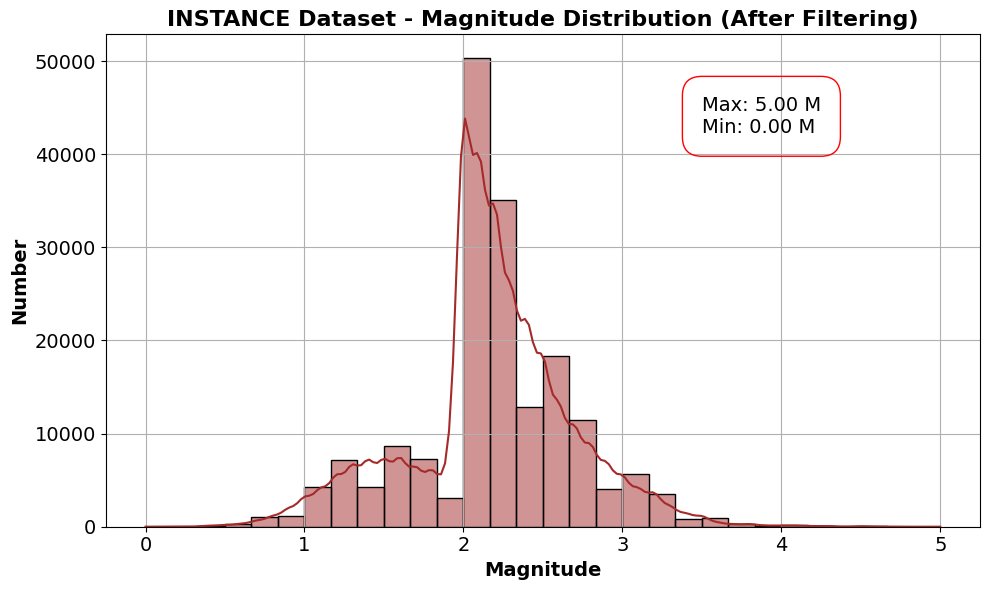

In [ ]:
# Plot the histogram of the earthquake magnitudes after filtering
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered["source_magnitude"], bins=30, kde=True, color='brown')
plt.xlabel('Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
max_magnitude = df_filtered["source_magnitude"].max()
min_magnitude = df_filtered["source_magnitude"].min()
plt.text(0.7*max_magnitude, plt.gca().get_ylim()[1]*0.8,
         f'Max: {max_magnitude:.2f} M\nMin: {min_magnitude:.2f} M',
         bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'), fontsize=14)
plt.title('INSTANCE Dataset - Magnitude Distribution (After Filtering)', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

Plot the histogram of the earthquake path epicenter distance after filtering

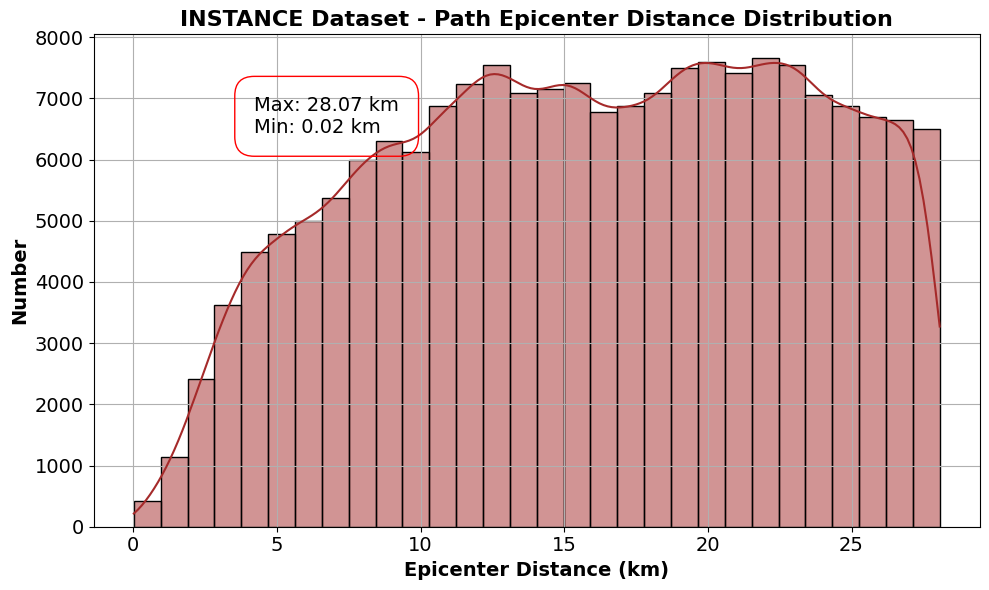

In [ ]:
# Plot the histogram of the earthquake path epicenter distance (lower than 28.07 km) after filtering
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered["path_ep_distance_km"], bins=30, kde=True, color='brown')
plt.xlabel('Epicenter Distance (km)', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
max_distance = df_filtered["path_ep_distance_km"].max()
min_distance = df_filtered["path_ep_distance_km"].min()
plt.text(0.15*max_distance, plt.gca().get_ylim()[1]*0.8,
         f'Max: {max_distance:.2f} km\nMin: {min_distance:.2f} km',
         bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'), fontsize=14)
plt.title('INSTANCE Dataset - Path Epicenter Distance Distribution', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# # Calculate the median epicenter distance after filtering
# median_distance = df_filtered["path_ep_distance_km"].median()

# # Plot the histogram of the earthquake path epicenter distance after filtering
# plt.figure(figsize=(10, 6))
# sns.histplot(df_filtered["path_ep_distance_km"], bins=30, kde=True, color='brown')
# plt.xlabel('Epicenter Distance (km)', fontweight='bold', fontsize=14)
# plt.ylabel('Number', fontweight='bold', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=14)
# plt.grid(True)
# max_distance = df_filtered["path_ep_distance_km"].max()
# min_distance = df_filtered["path_ep_distance_km"].min()
# plt.text(0.15*max_distance, plt.gca().get_ylim()[1]*0.8,
#          f'Max: {max_distance:.2f} km\nMin: {min_distance:.2f} km',
#          bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'), fontsize=14)

# # Add a vertical line at the median epicenter distance
# plt.axvline(x=median_distance, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_distance:.2f} km')

# # INSTANCE dataset - Path Epicenter Distance Distribution after filtering
# plt.title('INSTANCE Dataset - Path Epicenter Distance Distribution', fontweight='bold', fontsize=16)
# plt.legend()
# plt.tight_layout()
# plt.show()

# print(f"The median epicenter distance is: {median_distance:.2f} km")

Cell 5: Data Loading Function

In [ ]:
"""Cell 5: Data Loading Function (Same as Event-Based)"""

# Function to load seismogram data from HDF5 file (same as event-based)
def load_seismogram_instance(hdf5_path, seismogram_id, metadata_row):
    """
    Load a single seismogram from the INSTANCE HDF5 file

    Args:
        hdf5_path: Path to the HDF5 file
        seismogram_id: ID of the seismogram to load (trace_name)
        metadata_row: Row from metadata containing trace information

    Returns:
        Tuple of (data, magnitude) or (None, None) if seismogram not found

    Notes:
        - Data is a 30-second window: 5s before P-arrival and 25s after
        - Resampled to 100Hz if necessary
    """
    try:
        with h5py.File(hdf5_path, 'r') as hdf:
            # Parse the trace name to get bucket and trace index
            bucket, trace_info = seismogram_id.split('$')
            trace_index = int(trace_info.split(',')[0])

            # Retrieve waveform data
            waveform = np.array(hdf['data'][bucket][trace_index])

            sampling_rate = metadata_row['trace_sampling_rate_hz']
            spt = int(metadata_row['trace_P_arrival_sample'])

            # Adjust window size based on sampling rate
            window_samples = int(30 * sampling_rate)  # 30 seconds window
            start = max(0, spt - int(5 * sampling_rate))  # 5 seconds before P arrival
            end = start + window_samples

            if start >= waveform.shape[1] or end > waveform.shape[1]:
                print(f"Skipping event {seismogram_id}: Invalid window")
                return None, None

            dshort = waveform[:, start:end]

            # Ensure the shape is correct
            if dshort.shape[1] != window_samples:
                print(f"Skipping event {seismogram_id}: Incorrect window size")
                return None, None

            # Resample to 100 Hz if necessary
            if sampling_rate != 100:
                dshort = scipy.signal.resample(dshort, 3000, axis=1)

            mag = round(float(metadata_row['source_magnitude']), 2)

            return dshort, mag

    except Exception as e:
        print(f"Error processing event {seismogram_id}: {e}")
        return None, None

Cell 6: Load All Seismograms (Simplified - No Event Grouping)

In [ ]:
"""Cell 6: Load All Seismograms (Simplified for Seismogram-Based)"""

# Load all valid seismograms - simpler than event-based since no grouping needed
print("Loading all valid seismograms for seismogram-based splitting...")
all_data = []
all_labels = []
all_seismogram_ids = []

# Create a lookup dictionary for metadata rows
metadata_lookup = {row['trace_name']: row for _, row in df_filtered.iterrows()}

# Get list of all valid seismogram IDs
valid_seismogram_ids = df_filtered['trace_name'].tolist()
print(f"Number of seismograms to load: {len(valid_seismogram_ids)}")

# Load seismograms with progress tracking
for seis_id in tqdm(valid_seismogram_ids, desc="Loading seismograms"):
    if seis_id not in metadata_lookup:
        continue

    metadata_row = metadata_lookup[seis_id]
    data, label = load_seismogram_instance(hdf5_path, seis_id, metadata_row)

    if data is None:
        continue

    all_data.append(data)
    all_labels.append(label)
    all_seismogram_ids.append(seis_id)

# Convert lists to numpy arrays
all_data = np.array(all_data)
all_labels = np.array(all_labels)
all_seismogram_ids = np.array(all_seismogram_ids)

print(f"Final dataset: {len(all_data)} seismograms")
print(f"Data shape: {all_data.shape}, Labels shape: {all_labels.shape}")

# For comparison with event-based approach
unique_events = df_filtered['source_id'].nunique() if 'source_id' in df_filtered.columns else df_filtered['source_event_id'].nunique()
avg_seismograms_per_event = len(all_data) / unique_events
print(f"Average seismograms per event: {avg_seismograms_per_event:.2f}")
print(f"Note: In seismogram-based splitting, these {len(all_data)} seismograms will be split randomly")
print(f"      regardless of which event they belong to, potentially causing data leakage.")

# Save seismogram IDs mapping
with open(os.path.join(output_dir, 'seismogram_indices.pkl'), 'wb') as f:
    pickle.dump({
        'seismogram_ids': all_seismogram_ids,
    }, f)

Loading all valid seismograms for seismogram-based splitting...
Number of seismograms to load: 181093


Loading seismograms: 100%|██████████| 181093/181093 [10:41<00:00, 282.18it/s] 


Final dataset: 181093 seismograms
Data shape: (181093, 3, 3000), Labels shape: (181093,)
Average seismograms per event: 6.25
Note: In seismogram-based splitting, these 181093 seismograms will be split randomly
      regardless of which event they belong to, potentially causing data leakage.


Cell 7: Visualize Sample Seismograms

Plotting example seismograms for seismogram-based approach:

Example 1:


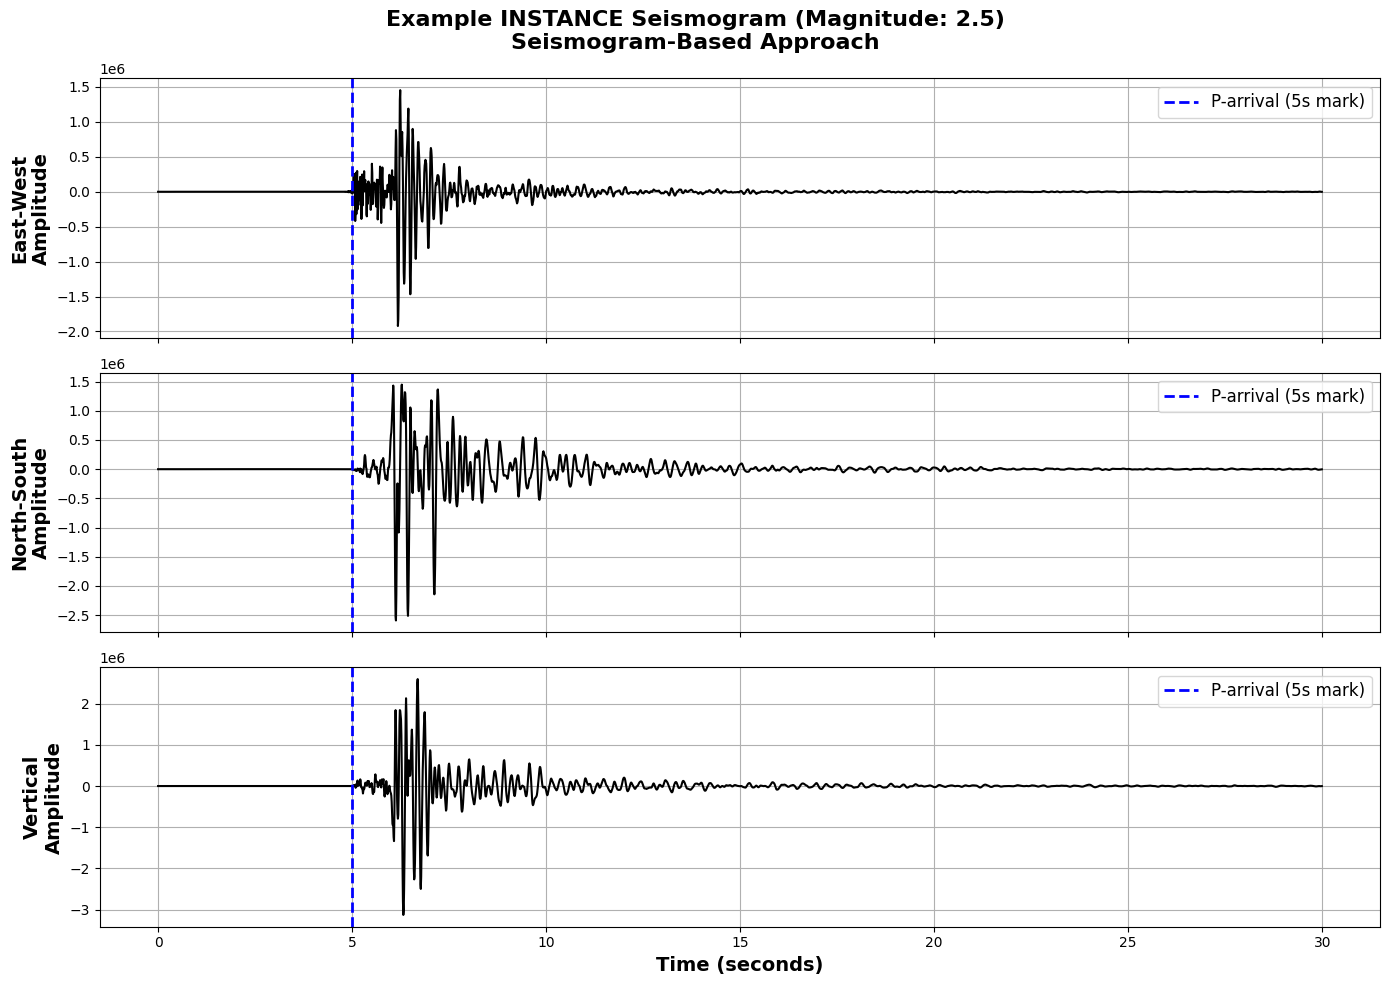


Example 101:


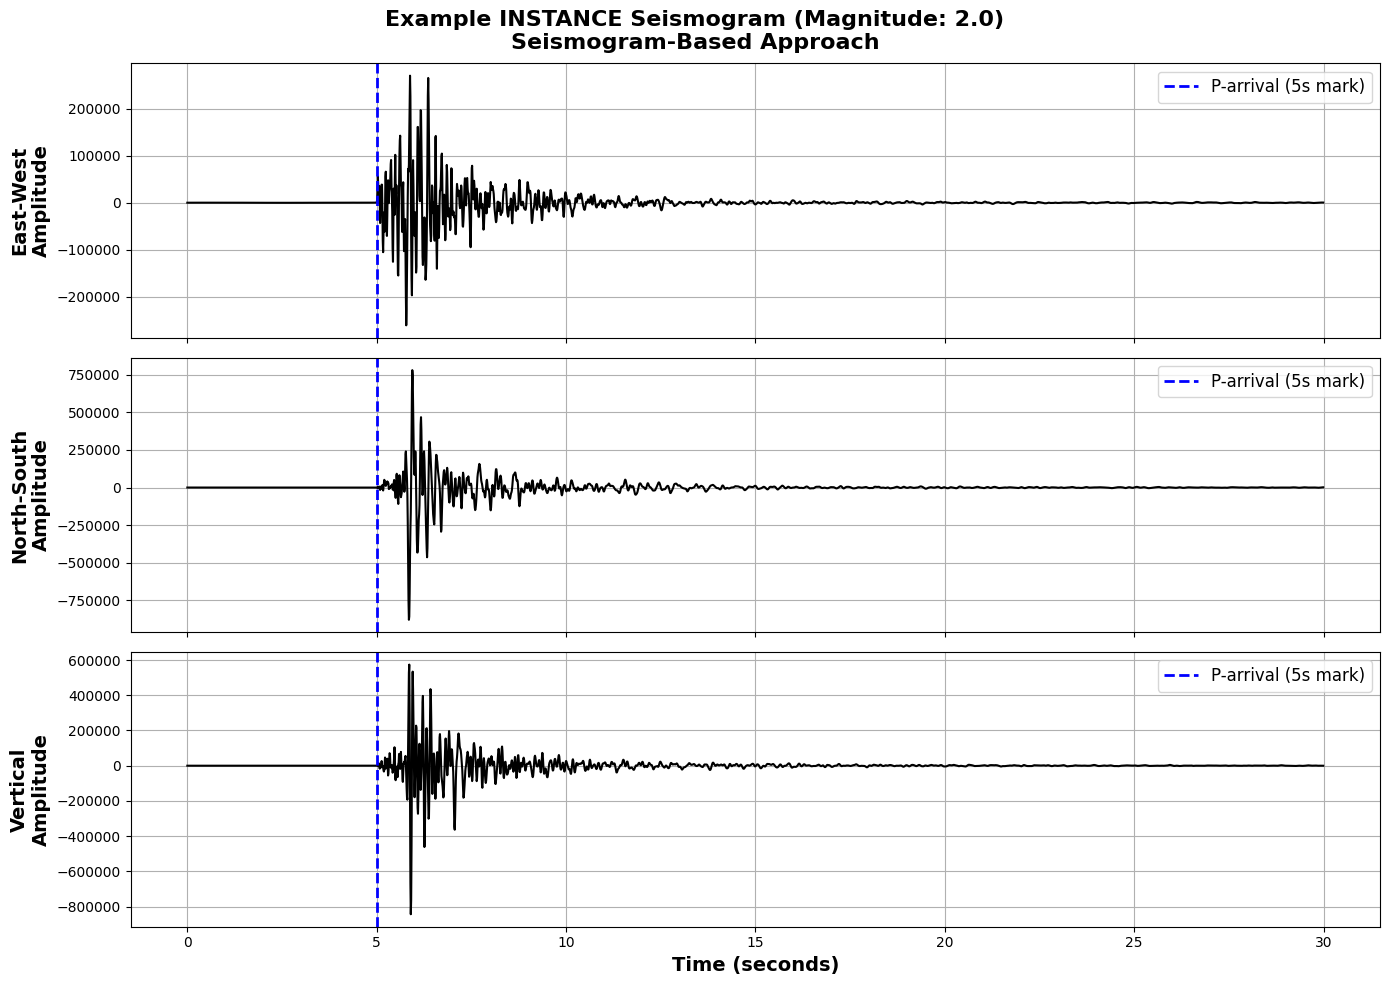


Example 501:


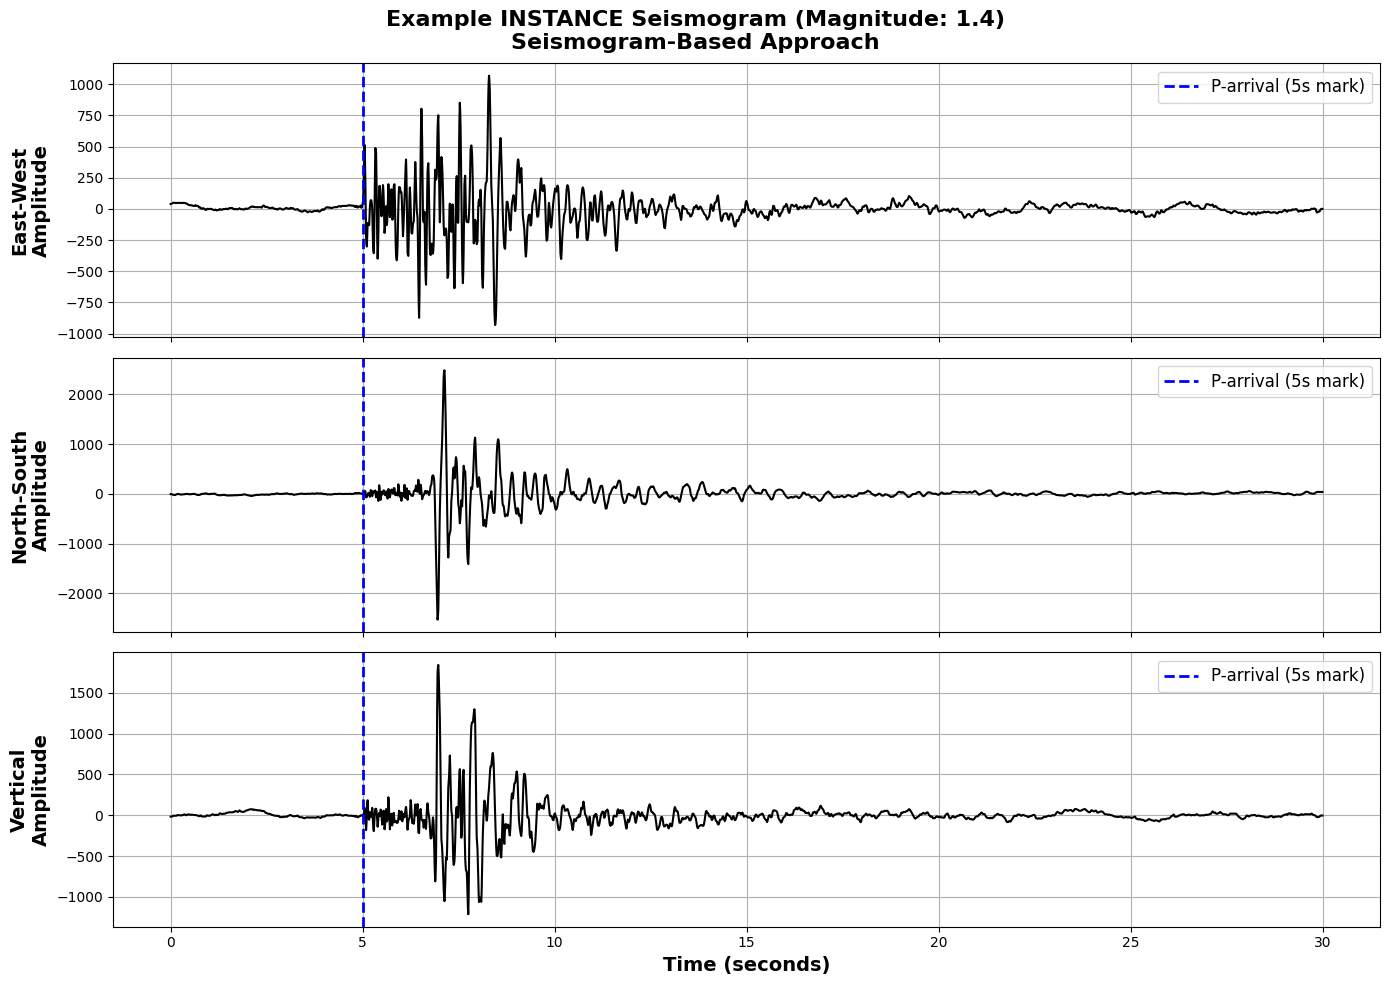

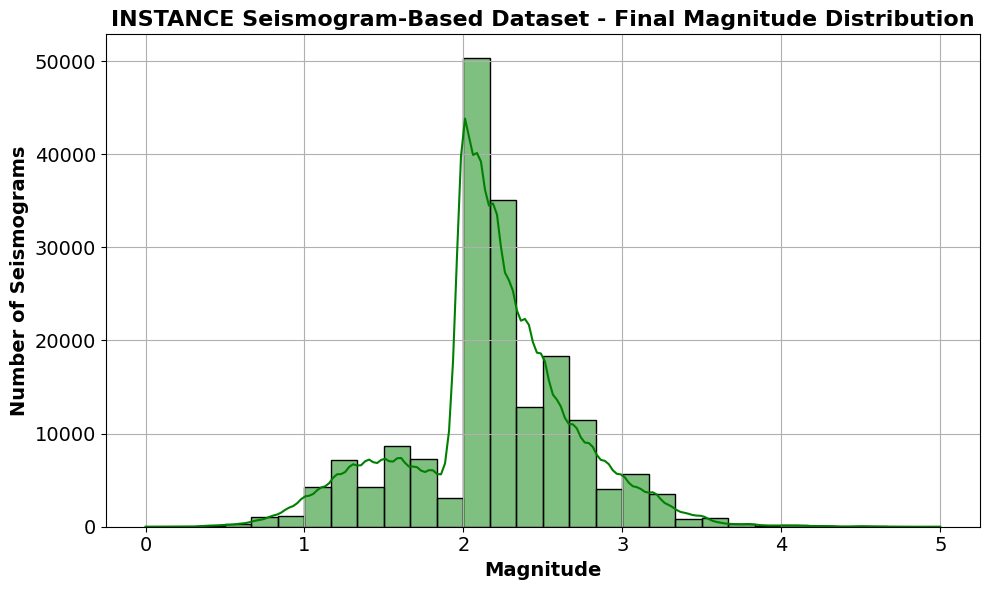

In [ ]:
"""Cell 7: Visualize Sample Seismograms"""

# Plot an example seismogram
def plot_example_seismogram_instance(data, labels, index=0):
    """Plot an example three-component seismogram"""
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    time = np.arange(data.shape[2]) / 100  # Convert to seconds (100Hz sampling)
    components = ['East-West', 'North-South', 'Vertical']

    for i in range(3):
        axes[i].plot(time, data[index, i, :], 'k')
        axes[i].set_ylabel(f'{components[i]}\nAmplitude', fontweight='bold', fontsize=14)
        axes[i].axvline(x=5.0, color='blue', linestyle='--', linewidth=2,
                      label='P-arrival (5s mark)')
        axes[i].grid(True)
        axes[i].legend(fontsize=12)

    axes[2].set_xlabel('Time (seconds)', fontweight='bold', fontsize=14)
    plt.suptitle(f'Example INSTANCE Seismogram (Magnitude: {labels[index]})\nSeismogram-Based Approach',
                fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot multiple example seismograms
if len(all_data) > 0:
    print("Plotting example seismograms for seismogram-based approach:")
    for i in [0, 100, 500]:  # Plot a few different examples
        if i < len(all_data):
            print(f"\nExample {i+1}:")
            plot_example_seismogram_instance(all_data, all_labels, i)

# Plot magnitude distribution
plt.figure(figsize=(10, 6))
sns.histplot(all_labels, bins=30, kde=True, color='green')
plt.xlabel('Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Number of Seismograms', fontweight='bold', fontsize=14)
plt.title('INSTANCE Seismogram-Based Dataset - Final Magnitude Distribution', fontweight='bold', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Cell 8: Save Data and Create Split Information

In [ ]:
"""Cell 8: Save Data and Create Split Information"""

# Convert to tensors
all_data_tensor = torch.tensor(all_data, dtype=torch.float32)
all_labels_tensor = torch.tensor(all_labels, dtype=torch.float32)

# Save the entire dataset
print("Saving data files...")
torch.save(all_data_tensor, os.path.join(output_dir, 'all_data.pt'))
torch.save(all_labels_tensor, os.path.join(output_dir, 'all_labels.pt'))

# Create seismogram-based split information (much simpler than event-based)
def generate_seismogram_based_split_info(num_samples, train_ratio=0.7, val_ratio=0.1):
    """
    Generate split information for seismogram-based random splits

    Args:
        num_samples: Total number of seismograms
        train_ratio: Proportion for training set
        val_ratio: Proportion for validation set

    Returns:
        Dictionary with split information for random seismogram-based splits
    """
    return {
        'num_samples': num_samples,
        'train_ratio': train_ratio,
        'val_ratio': val_ratio,
        'splitting_approach': 'seismogram_based',
        'note': 'Seismograms split randomly regardless of event membership'
    }

# Generate split information
print("Preparing split information for seismogram-based experiments...")
split_info = generate_seismogram_based_split_info(len(all_data))

# Save split information
with open(os.path.join(output_dir, 'seismogram_split_info.pkl'), 'wb') as f:
    pickle.dump(split_info, f)

# Save additional metadata for comparison purposes
comparison_data = {
    'total_seismograms': len(all_data),
    'unique_events': unique_events,
    'avg_seismograms_per_event': avg_seismograms_per_event,
    'approach': 'seismogram_based',
    'potential_data_leakage': True,
    'comparison_note': 'Unlike event-based splitting, this approach may have seismograms from the same event in different splits'
}

with open(os.path.join(output_dir, 'comparison_info.pkl'), 'wb') as f:
    pickle.dump(comparison_data, f)

Saving data files...
Preparing split information for seismogram-based experiments...


Cell 9: Summary and Final Statistics

In [ ]:
"""Cell 9: Summary and Final Statistics"""

print("\n" + "="*80)
print("INSTANCE SEISMOGRAM-BASED PREPROCESSING COMPLETED")
print("="*80)

print(f"\nFiles created in the output directory:")
print(f"1. all_data.pt - All seismogram data tensors")
print(f"2. all_labels.pt - All magnitude labels")
print(f"3. seismogram_split_info.pkl - Information for random seismogram-based splits")
print(f"4. seismogram_indices.pkl - Mapping of seismogram IDs")
print(f"5. multi_observations.npy - List of stations with ≥400 observations")
print(f"6. comparison_info.pkl - Comparison data for analysis")

print(f"\nFinal Dataset Summary:")
print(f"Total seismograms: {len(all_data)}")
print(f"Unique events represented: {unique_events}")
print(f"Average seismograms per event: {avg_seismograms_per_event:.2f}")
print(f"Data shape: {all_data.shape}")

print(f"\nSplitting Approach: SEISMOGRAM-BASED")
print(f"- Seismograms will be split randomly regardless of event membership")
print(f"- This may result in seismograms from the same event appearing in different splits")
print(f"- Expected to show data leakage effects compared to event-based splitting")

# Report execution time
end_time = time.time()
print(f"\nTotal execution time: {(end_time - start_time) / 60:.2f} minutes")

print(f"\nINSTANCE seismogram-based preprocessing completed successfully!")
print(f"Ready for comparison with event-based approach:")
print(f"   Event-based (10.64 seismograms/event) vs Seismogram-based (random splitting)")
print(f"Used SeisBench download - no Google Drive quota issues!")

print(f"\nNext steps:")
print(f"1. Run INSTANCE_50_Experiments_Seismogram_Based_Splits_Runs_1_to_25.ipynb")
print(f"2. Run INSTANCE_50_Experiments_Seismogram_Based_Splits_Runs_26_to_50.ipynb")
print(f"3. Compare results with event-based splitting experiments")


INSTANCE SEISMOGRAM-BASED PREPROCESSING COMPLETED

Files created in the output directory:
1. all_data.pt - All seismogram data tensors
2. all_labels.pt - All magnitude labels
3. seismogram_split_info.pkl - Information for random seismogram-based splits
4. seismogram_indices.pkl - Mapping of seismogram IDs
5. multi_observations.npy - List of stations with ≥400 observations
6. comparison_info.pkl - Comparison data for analysis

Final Dataset Summary:
Total seismograms: 181093
Unique events represented: 28966
Average seismograms per event: 6.25
Data shape: (181093, 3, 3000)

Splitting Approach: SEISMOGRAM-BASED
- Seismograms will be split randomly regardless of event membership
- This may result in seismograms from the same event appearing in different splits
- Expected to show data leakage effects compared to event-based splitting

Total execution time: 120.92 minutes

INSTANCE seismogram-based preprocessing completed successfully!
Ready for comparison with event-based approach:
   Even